Comparison between 
- $D(X_{1:n} || Y_{1:m})$, $D(X^{(p)}_{1:n} || Y_{1:m})$
- $D(X_{1:n} || q)$, $D(X^{(p)}_{1:n} || q)$
as n varies

versus 
$D(X_{1:n} || Y_{1:m})$ and - $D(X^{(p)}_{1:n} || Y_{1:m})$
with very high $n$ and $m$. 


In [1]:
import numpy as np
from scipy.special import gamma as Gamma
from scipy.special import gammaln as GammaLn
from numpy.random import multivariate_normal as mvn 
from scipy.stats import multivariate_normal as multinorm
#
from sklearn.neighbors import NearestNeighbors
# -- nonGaussLike -- 
from nongausslike import knn as kNN
from nongausslike import nongauss as NG

In [2]:
import matplotlib as mpl 
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline

In [3]:
def c_1(d): 
    return np.pi**(0.5 * float(d)) / Gamma(0.5*float(d)+1)

def hat_p(X, k=10): 
    n, d = X.shape # n and dimensions
    k, n, d = float(k), float(n), float(d)

    # kNN term
    NN_X = NearestNeighbors(n_neighbors=int(k)).fit(X)
    dNN_XX, _ = NN_X.kneighbors(X, n_neighbors=int(k)+1) # k+1 to exclude itself
    rho_k_i = dNN_XX[:,-1]
    
    return k/(n-1) * 1 / (c_1(d) * rho_k_i**d)

def KL_Xq(X, q, k=10): 
    ''' X is a matrix, k is float, q is a function 
    '''
    try: 
        n, d = X.shape
    except ValueError: 
        n, d = X.reshape(-1,1).shape

    p_Xi = hat_p(X, k=k)
    q_Xi = q(X)
    return np.sum(np.log(p_Xi) - np.log(q_Xi))/n

In [4]:
def avgKL_XY_redBias(X, m, n_sample=10, Cov=None): 
    ''' reduced bias Wang et al. (2009) Eq. 29 estimator
    '''
    d = X.shape[1]
    _kl = []
    for i in range(n_sample): 
        Y = mvn(np.zeros(d), Cov, size=m)
        _kl.append(kNN.KL_w2009_eq29(X, Y))
    return np.average(_kl)

In [5]:
def avgKL_XY_SKL(X, m, k, div_func='kl', n_sample=10, Cov=None): 
    d = X.shape[1]
    _kl = []
    for i in range(n_sample): 
        Y = mvn(np.zeros(d), Cov, size=m)
        _kl.append(NG.kNNdiv_gauss(X, None, Knn=k, div_func=div_func, gauss=Y))
    return np.average(_kl)

In [6]:
X_pk = NG.X_pk_all('patchy.z1', NorS='ngc', sys='fc')
X_res, _ = NG.meansub(X_pk)
X_w, W = NG.whiten(X_res)
C_x = np.cov(X_w.T)

n, dim = X_pk.shape
print("%i dimensional data with %i samples" % (dim, n))

C_x_p = np.zeros(C_x.shape)
for i in range(C_x.shape[0]): 
    for j in range(C_x.shape[1]): 
        if i != j: 
            C_x_p[i,j] = 1.1 * C_x[i,j]

37 dimensional data with 2048 samples


In [7]:
def Xsample(n): 
    return mvn(np.zeros(dim), C_x, size=n)

def Xpsample(n): 
    return mvn(np.zeros(dim), C_x_p, size=n)

In [9]:
m_fixed = 20000
k = 2

In [10]:
X_ref_dense = Xsample(20000)
X_p_ref_dense = Xpsample(20000)

In [11]:
DXY_true = avgKL_XY_SKL(X_ref_dense, m_fixed, k, Cov=C_x)
DXpY_true = avgKL_XY_SKL(X_p_ref_dense, m_fixed, k, Cov=C_x)

DXY_rb_true = avgKL_XY_redBias(X_ref_dense, m_fixed, Cov=C_x)
DXpY_rb_true = avgKL_XY_redBias(X_p_ref_dense, m_fixed, Cov=C_x)

In [12]:
ns = [1000, 2000, 3000, 5000, 8000]
X_ref_ns, X_p_ref_ns = [], []
for n in ns: 
    X_ref_ns.append(Xsample(n))
    X_p_ref_ns.append(Xpsample(n))

In [13]:
qX = lambda x: multinorm.pdf(x, mean=np.zeros(dim), cov=C_x)

KL_Xq_ns, KL_Xpq_ns = [], []
for i in range(len(ns)): 
    KL_Xq_ns.append(KL_Xq(X_ref_ns[i], qX, k=k))
    KL_Xpq_ns.append(KL_Xq(X_p_ref_ns[i], qX, k=k))

In [14]:
KL_XY_ns, KL_XpY_ns = [], []
for i in range(len(ns)): 
    KL_XY_ns.append(avgKL_XY_SKL(X_ref_ns[i], m_fixed, k, Cov=C_x))
    KL_XpY_ns.append(avgKL_XY_SKL(X_p_ref_ns[i], m_fixed, k, Cov=C_x))

In [15]:
KL_XY_rb_ns, KL_XpY_rb_ns = [], []
for i in range(len(ns)): 
    KL_XY_rb_ns.append(avgKL_XY_redBias(X_ref_ns[i], m_fixed, Cov=C_x))
    KL_XpY_rb_ns.append(avgKL_XY_redBias(X_p_ref_ns[i], m_fixed, Cov=C_x))

Text(0,0.5,'KL Divergence')

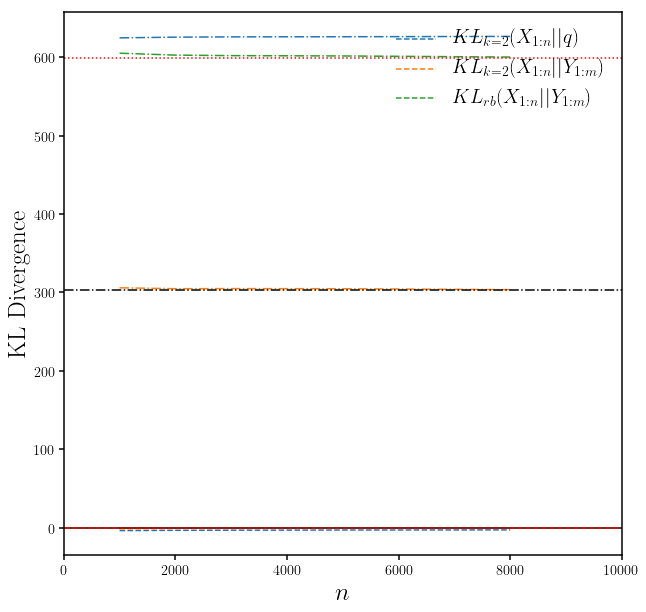

In [24]:
fig = plt.figure(figsize=(10,10))
sub = fig.add_subplot(111)
sub.plot(ns, KL_Xq_ns, c='C0', ls='--', label='$KL_{k='+str(k)+'}(X_{1:n}||q)$')
sub.plot(ns, KL_Xpq_ns, c='C0', ls='-.')

sub.plot(ns, KL_XY_ns, c='C1', ls='--', label='$KL_{k='+str(k)+'}(X_{1:n}||Y_{1:m})$')
sub.plot(ns, KL_XpY_ns, c='C1', ls='-.')

sub.plot(ns, KL_XY_rb_ns, c='C2', ls='--', label='$KL_{rb}(X_{1:n}||Y_{1:m})$')
sub.plot(ns, KL_XpY_rb_ns, c='C2', ls='-.')

sub.plot([0, 10000], [DXY_true, DXY_true], c='k', ls='-')
sub.plot([0, 10000], [DXpY_true, DXpY_true], c='k', ls='-.')

sub.plot([0, 10000], [DXY_rb_true, DXY_rb_true], c='r', ls='--')
sub.plot([0, 10000], [DXpY_rb_true, DXpY_rb_true], c='r', ls=':')
sub.legend(loc='upper right', fontsize=20)
sub.set_xlabel('$n$', fontsize=25)
sub.set_xlim([0, 10000])
sub.set_ylabel('KL Divergence', fontsize=25)

In [39]:
def KL_XY_ns_skl(ns, m, k=2): 
    KL_XY_ns, KL_XpY_ns = [], []
    for i in range(len(ns)): 
        KL_XY_ns.append(avgKL_XY_SKL(X_ref_ns[i], m, k, Cov=C_x))
        KL_XpY_ns.append(avgKL_XY_SKL(X_p_ref_ns[i], m, k, Cov=C_x))
    return np.array(KL_XY_ns), np.array(KL_XpY_ns)

In [31]:
KL_XY_ns_m5000, KL_XpY_ns_m5000 = KL_XY_ns_skl(ns, 5000)

In [33]:
KL_XY_ns_m2000, KL_XpY_ns_m2000 = KL_XY_ns_skl(ns, 2000)

In [34]:
KL_XY_ns_m1000, KL_XpY_ns_m1000 = KL_XY_ns_skl(ns, 1000)

Text(0,0.5,'$\\Delta$ KL Divergence')

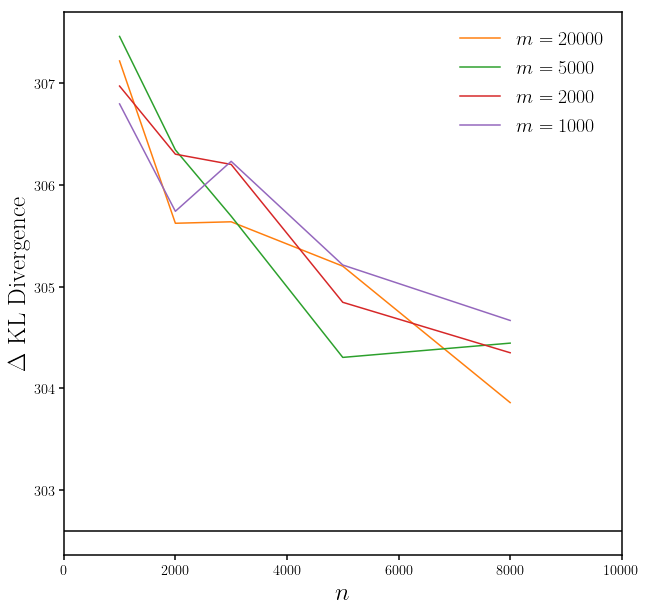

In [35]:
fig = plt.figure(figsize=(10,10))
sub = fig.add_subplot(111)

sub.plot(ns, np.array(KL_XpY_ns) - np.array(KL_XY_ns), c='C1', ls='-', label='$m=20000$')

sub.plot(ns, np.array(KL_XpY_ns_m5000) - np.array(KL_XY_ns_m5000), c='C2', ls='-', label='$m=5000$')

sub.plot(ns, np.array(KL_XpY_ns_m2000) - np.array(KL_XY_ns_m2000), c='C3', ls='-', label='$m=2000$')

sub.plot(ns, np.array(KL_XpY_ns_m1000) - np.array(KL_XY_ns_m1000), c='C4', ls='-', label='$m=1000$')

sub.plot([0, 10000], [np.array(DXpY_true) - np.array(DXY_true), np.array(DXpY_true) - np.array(DXY_true)], c='k', ls='-')

#sub.plot([0, 10000], [np.array(DXpY_rb_true) - np.array(DXY_rb_true), np.array(DXpY_rb_true) - np.array(DXY_rb_true)], c='r', ls='-')
sub.legend(loc='upper right', fontsize=20)
sub.set_xlabel('$n$', fontsize=25)
sub.set_xlim([0, 10000])
sub.set_ylabel('$\Delta$ KL Divergence', fontsize=25)

In [37]:
KL_XY_ns_k10, KL_XpY_ns_k10 = [], []
for i in range(len(ns)): 
    KL_XY_ns_k10.append(avgKL_XY_SKL(X_ref_ns[i], m_fixed, 10, Cov=C_x))
    KL_XpY_ns_k10.append(avgKL_XY_SKL(X_p_ref_ns[i], m_fixed, 10, Cov=C_x))

In [40]:
KL_XY_ns_m5000_k10, KL_XpY_ns_m5000_k10 = KL_XY_ns_skl(ns, 5000, k=10)

In [47]:
KL_XY_ns_m2000_k10, KL_XpY_ns_m2000_k10 = KL_XY_ns_skl(ns, 2000, k=10)

In [48]:
KL_XY_ns_m1000_k10, KL_XpY_ns_m1000_k10 = KL_XY_ns_skl(ns, 1000, k=10)

Text(0,0.5,'$\\Delta$ KL Divergence')

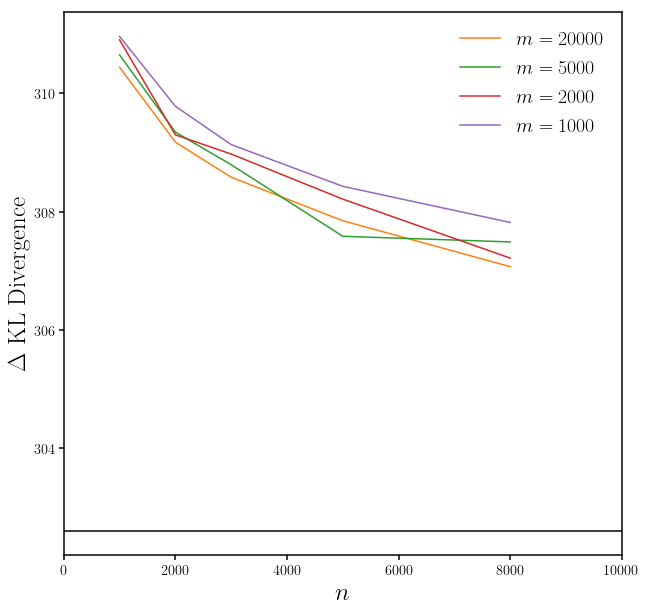

In [49]:
fig = plt.figure(figsize=(10,10))
sub = fig.add_subplot(111)

sub.plot(ns, np.array(KL_XpY_ns_k10) - np.array(KL_XY_ns_k10), c='C1', ls='-', label='$m=20000$')

sub.plot(ns, np.array(KL_XpY_ns_m5000_k10) - np.array(KL_XY_ns_m5000_k10), c='C2', ls='-', label='$m=5000$')

sub.plot(ns, np.array(KL_XpY_ns_m2000_k10) - np.array(KL_XY_ns_m2000_k10), c='C3', ls='-', label='$m=2000$')

sub.plot(ns, np.array(KL_XpY_ns_m1000_k10) - np.array(KL_XY_ns_m1000_k10), c='C4', ls='-', label='$m=1000$')

sub.plot([0, 10000], [np.array(DXpY_true) - np.array(DXY_true), np.array(DXpY_true) - np.array(DXY_true)], c='k', ls='-')

#sub.plot([0, 10000], [np.array(DXpY_rb_true) - np.array(DXY_rb_true), np.array(DXpY_rb_true) - np.array(DXY_rb_true)], c='r', ls='-')
sub.legend(loc='upper right', fontsize=20)
sub.set_xlabel('$n$', fontsize=25)
sub.set_xlim([0, 10000])
sub.set_ylabel('$\Delta$ KL Divergence', fontsize=25)

Text(0,0.5,'KL Divergence')

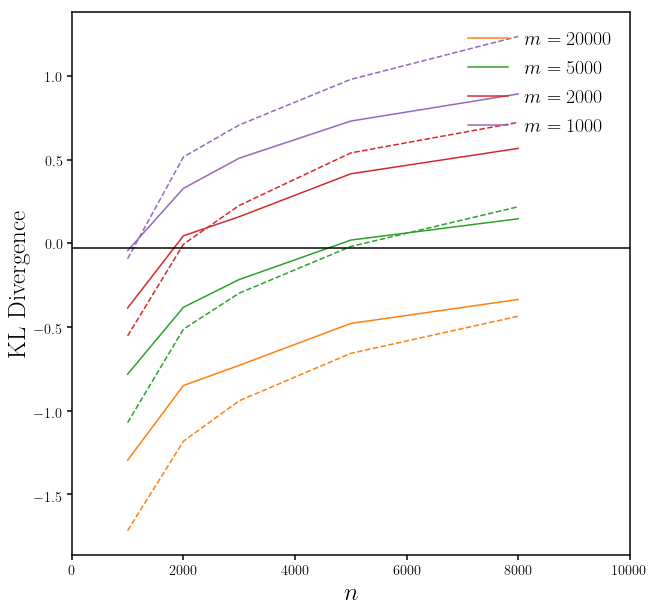

In [52]:
fig = plt.figure(figsize=(10,10))
sub = fig.add_subplot(111)

sub.plot(ns, np.array(KL_XY_ns), c='C1', ls='-', label='$m=20000$')
sub.plot(ns, np.array(KL_XY_ns_k10), c='C1', ls='--')

sub.plot(ns, np.array(KL_XY_ns_m5000), c='C2', ls='-', label='$m=5000$')
sub.plot(ns, np.array(KL_XY_ns_m5000_k10), c='C2', ls='--')

sub.plot(ns, np.array(KL_XY_ns_m2000), c='C3', ls='-', label='$m=2000$')
sub.plot(ns, np.array(KL_XY_ns_m2000_k10), c='C3', ls='--')

sub.plot(ns, np.array(KL_XY_ns_m1000), c='C4', ls='-', label='$m=1000$')
sub.plot(ns, np.array(KL_XY_ns_m1000_k10), c='C4', ls='--')

sub.plot([0, 10000], [np.array(DXY_true), np.array(DXY_true)], c='k', ls='-')

#sub.plot([0, 10000], [np.array(DXpY_rb_true) - np.array(DXY_rb_true), np.array(DXpY_rb_true) - np.array(DXY_rb_true)], c='r', ls='-')
sub.legend(loc='upper right', fontsize=20)
sub.set_xlabel('$n$', fontsize=25)
sub.set_xlim([0, 10000])
sub.set_ylabel('KL Divergence', fontsize=25)